勾配降下法で灯油タンクを探す
=====
***

- [地理院タイル一覧](http://maps.gsi.go.jp/development/ichiran.html)
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)
- [地理院タイル仕様](http://maps.gsi.go.jp/development/siyou.html)
- [標高タイルの詳細仕様](http://maps.gsi.go.jp/development/demtile.html)

## 1. 準備

### 1.1 import

In [1]:
import urllib
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

### 1.2 地理院タイルをダウンロードする関数・arrayとして取り込む関数

In [2]:
def maybe_download(url, name):
    """ ファイルがなければダウンロード """
    if not os.path.exists(name):
        urllib.urlretrieve(url, name)
        print "File " + name + " downloaded!"
    return name

def read_tile(name):
    """ csv file -> numpy array """
    ret = np.genfromtxt(name, delimiter=",", filling_values=0.) # 'e' -> 0.0 （海など?）
    if ret.shape == (256, 256):
        return ret
    else: # 国外だとデータがないので0としておく
        return np.zeros((256, 256))

### 1.3 任意の領域・ズームレベルで各種地理院タイルを取得する関数

#### 領域の定義
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)を開き、長方形領域の左上と右下のタイル座標を好きなズームレベルで指定する。
- 例えば、以下の画像で5/27/11から5/28/13までの縦長領域に関して好きなズームレベルで標高タイルを取得したいとする。
<img src="fig/japan.png" width="500">

#### タイル座標の取得
上記で指定した領域について、任意のズームレベルにおけるタイル座標をすべて取得する。

ズームレベルを1つ増やすごとにタイルが4倍になり、下図のようにタイル座標が変化することに注意。
<img src="fig/zoom.jpg" width="400">

In [3]:
def get_maps(from_tile, to_tile=None, zoom=None, tile_type="std", ext="png",):
    """ 指定された領域に含まれるすべての地図タイルを任意のズームレベルで取得する
    Inputs:
        file_type, ext: 取得したいタイルの種類・拡張子
        -> http://cyberjapandata.gsi.go.jp/xyz/<tile_type>/{z}/{x}/{y}.<ext>を取得する
        from_tile, to_tile: 取得したい領域内の左上、右下のタイル座標（それぞれ[z, x, y]のリスト）
        zoom: ズームレベル
    Outputs:
        full_tile: 指定した領域の地図タイルを結合したもの（numpyのarray）
    """
    if zoom == None:# zoomを省略するとfrom_tileと同じになる
        zoom =from_tile[0]
    if to_tile == None:# to_tileを省略するとfrom_tileと同じになる
        to_tile = from_tile
    MAX_ZOOM = 18
    assert zoom <= MAX_ZOOM

    # 指定されたzoomにおける左上のタイル座標
    x1 = from_tile[1] * 2**(zoom - from_tile[0])
    y1 = from_tile[2] * 2**(zoom - from_tile[0])
    # 指定されたzoomにおける右下のタイル座標
    x2 = (to_tile[1] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    y2 = (to_tile[2] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    
    # 左上〜右下すべてのタイルの座標
    tile_list = []
    for j in range(y1, y2+1):
        tile_row = []
        for i in range(x1, x2+1):
            tile_row.append([zoom, i, j])
        tile_list.append(tile_row)
    
    # ダウンロード
    full_tile = []
    for tile_row in tile_list:
        tr = []
        for tile in tile_row:
            tile_url = "http://cyberjapandata.gsi.go.jp/xyz/{tile_type}/{z}/{x}/{y}.{ext}".format(tile_type=tile_type, 
                                                                                                  z=tile[0], x=tile[1], y=tile[2],
                                                                                                  ext=ext)
            if ext=="png" or ext=="jpg":
                tile_name = "{ext}/{tile_type}_{z}_{x}_{y}.{ext}".format(ext=ext, tile_type=tile_type, z=tile[0], x=tile[1], y=tile[2])
                maybe_download(tile_url, tile_name)
                tr.append(np.array(Image.open(tile_name)))
            elif ext=="txt":
                # save as .csv
                tile_name = "csv/{tile_type}_{z}_{x}_{y}.csv".format(tile_type=tile_type, z=tile[0], x=tile[1], y=tile[2])
                maybe_download(tile_url, tile_name)
                tr.append(read_tile(tile_name)) # 'e'->0.0
            else:
                raise ValueError(".jpg, .png, .txt supported")
        full_tile.append(np.hstack(tr))
    full_tile = np.vstack(full_tile)
    return full_tile

#### Usage

(256, 256)
(256, 256, 3)
(256, 256, 3)


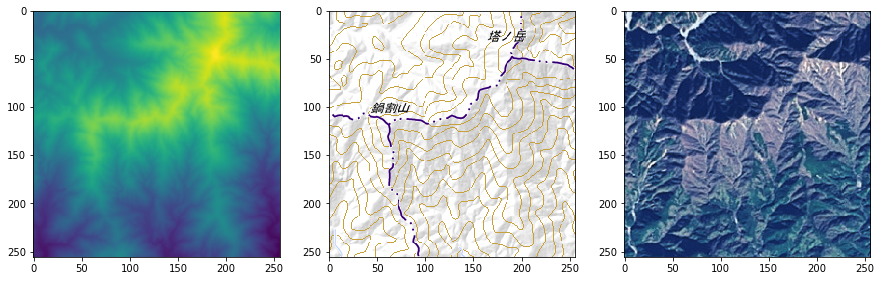

In [5]:
# タイル座標13/7262/3232の,

# 標高タイルを取得したい場合
nabewari_dem = get_maps([13, 7262, 3232], tile_type="dem", ext="txt")
print nabewari_dem.shape # 地理院タイルは1つあたり256x256

# 標準地図タイルを取得したい場合
nabewari_std = get_maps([13, 7262, 3232], tile_type="std", ext="png")
print nabewari_std.shape # 地理院タイルは1つあたり256x256

# 写真タイルを取得したい場合
nabewari_seamlessphoto = get_maps([13, 7262, 3232], tile_type="seamlessphoto", ext="jpg")
print nabewari_seamlessphoto.shape # 地理院タイルは1つあたり256x256

# plot
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(nabewari_dem, interpolation="none")

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(nabewari_std, interpolation="none")

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(nabewari_seamlessphoto, interpolation="none")

(768, 512)
(3072, 2048)


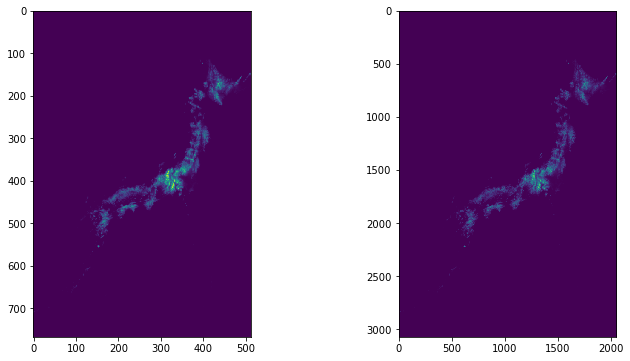

In [7]:
# タイル座標5/27/11から5/28/13の標高タイルをまとめて取得したい場合
japan_tile = get_maps([5, 27, 11], [5, 28, 13], tile_type="dem", ext="txt")
print japan_tile.shape

# 同じくタイル座標5/27/11から5/28/13の標高タイルを、もっと細かく（ズームレベル7で）取得したい場合
japan_tile2 = get_maps([5, 27, 11], [5, 28, 13], zoom=7, tile_type="dem", ext="txt")
print japan_tile2.shape

# plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(japan_tile, interpolation="none")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(japan_tile2, interpolation="none")

## 2. 勾配の計算

### 2.1 勾配の計算方法
地理院タイルでは格子点上の標高が記されている（下図の正方形の頂点）。その隙間の任意の地点$(x, y)$での勾配を知りたいので、下図の右下のように各格子を2つの三角形（上から見ると直角二等辺三角形に見える）に分割し、その平面の方程式を通して勾配を計算する。
<img src="fig/grad.png", width=400></img>
- (1) 点$(x, y)$が$(x-[x])+(y-[y]) < 1$を満たす（図の灰色の三角形に属する）とき:

    3点$([x],\: [y],\: z_0),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_1 - z_0, \: \: \frac{\partial z}{\partial y} = z_2 - z_0
$$

- (2) 点$(x, y)$が$(x-[x])+(y-[y]) \geq 1$を満たす（図の水色の三角形に属する）とき:

    3点$([x]+1,\: [y]+1,\: z_3),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_3 - z_2, \: \: \frac{\partial z}{\partial y} = z_3 - z_1
$$

In [8]:
def gradient(tile, x, y):
    """ 指定された標高タイル上の任意の地点での勾配を計算する
    Inputs: 
        tile: 標高タイル
        x, y: 勾配を計算したい地点の座標
    Outputs:
        grad_x, grad_y: 勾配のx, y成分
    """
    fx, fy = int(x), int(y) # floor
    dx, dy = x-int(x), y-int(y) # decimal part
    if (dx + dy) < 1:
        grad_x = tile[fy, fx+1] - tile[fy, fx]
        grad_y = tile[fy+1, fx] - tile[fy, fx]
    else:
        grad_x = tile[fy+1, fx+1] - tile[fy+1, fx]
        grad_y = tile[fy+1, fx+1] - tile[fy, fx+1]
    return grad_x, grad_y

- 標高はメートルなのに対してx, yはズームレベルにより異なることに注意。勾配降下法を用いる分には問題ない。

In [10]:
# Usage
print gradient(nabewari_dem, 12.34, 56.78)

(-18.700000000000045, -2.8300000000000409)


### 2.2 勾配の可視化

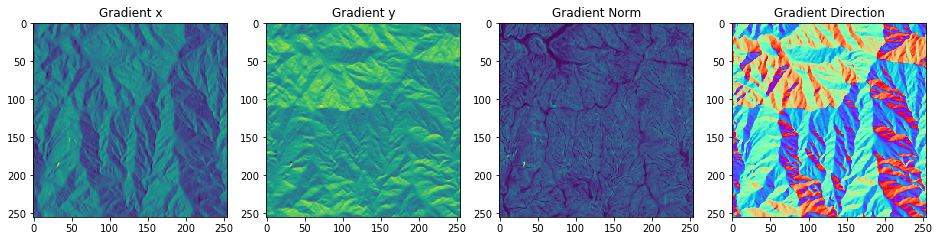

In [16]:
gx = np.zeros((nabewari_dem.shape[0]-1, nabewari_dem.shape[1]-1)) # x方向の勾配
gy = np.zeros((nabewari_dem.shape[0]-1, nabewari_dem.shape[1]-1)) # y方向の勾配
g  = np.zeros((nabewari_dem.shape[0]-1, nabewari_dem.shape[1]-1)) # 勾配の絶対値
gt = np.zeros((nabewari_dem.shape[0]-1, nabewari_dem.shape[1]-1)) # 勾配の方向

for i in range(nabewari_dem.shape[0]-1):
    for j in range(nabewari_dem.shape[1]-1):
        gx[i, j] = gradient(nabewari_dem, j, i)[0]
        gy[i, j] = gradient(nabewari_dem, j, i)[1]
        g[i, j] = np.sqrt(gradient(nabewari_dem, j, i)[0]**2 + gradient(nabewari_dem, j, i)[1]**2)
        gt[i, j] = np.arctan2(gradient(nabewari_dem, j, i)[1], gradient(nabewari_dem, j, i)[0])

# plot
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 4, 1)
plt.title("Gradient x")
ax.imshow(gx, interpolation="none")

ax2 = fig.add_subplot(1, 4, 2)
plt.title("Gradient y")
ax2.imshow(gy, interpolation="none")

ax3 = fig.add_subplot(1, 4, 3)
plt.title("Gradient Norm")
ax3.imshow(g, interpolation="none")

ax4 = fig.add_subplot(1, 4, 4)
plt.title("Gradient Direction")
ax4.imshow(gt, interpolation="none", cmap="rainbow")

## 3. Gradient Descentで坂を下る
初期地点を$(x_0, y_0)$として、以下のように勾配を下る
$$
\begin{align}
x_{k+1} = x_{k} - \epsilon \frac{\partial z}{\partial x} \\
y_{k+1} = y_{k} - \epsilon \frac{\partial z}{\partial y}
\end{align}
$$

TODO: Momentum, etc

http://postd.cc/optimizing-gradient-descent/

http://distill.pub/2017/momentum/

In [17]:
# 以下を考慮してεのオーダーを考える（このgx, gyはnabewari_demの各点でのgradientを収めたarray）
print gx.min(), gx.max()
print gy.min(), gy.max()

-26.07 47.56
-39.54 27.63


In [18]:
def show_gradient_descent(tile, start_point, eps=0.1, max_step=1000, map_=None):
    """ 勾配降下法で斜面を下る過程を可視化する
    Inputs:
        tile: 標高タイル
        start_point: 下り始める地点(x,y)
        eps: 座標の更新の係数
        max_step: 最大ステップ数
        map_: tileに対応する領域の地図画像
    Outputs:
        returnせず、グラフを描画
    """
    x, y = start_point
    x_list = [x]
    y_list = [y]
    for _ in range(max_step):
        try:
            gx, gy = gradient(tile, x, y)
        except IndexError:
            break
        x = x - eps * gx
        y = y - eps * gy
        x_list.append(x)
        y_list.append(y)
    
    # visualize
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_list)
    plt.xlabel("step"), plt.ylabel("x")
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(y_list)
    plt.xlabel("step"), plt.ylabel("y")

    if map_ is not None:
        fig = plt.figure(figsize=(16, 6))
        ax = fig.add_subplot(1, 2, 1)
        im = ax.imshow(tile, interpolation="none")
        ax.plot(x_list, y_list, color="red")
        plt.colorbar(im)
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.imshow(map_)
        ax2.plot(x_list, y_list, color="red")
    else:
        fig = plt.figure(figsize=(8, 6))
        plt.imshow(tile, interpolation="none")
        plt.plot(x_list, y_list, color="red")
        plt.colorbar()

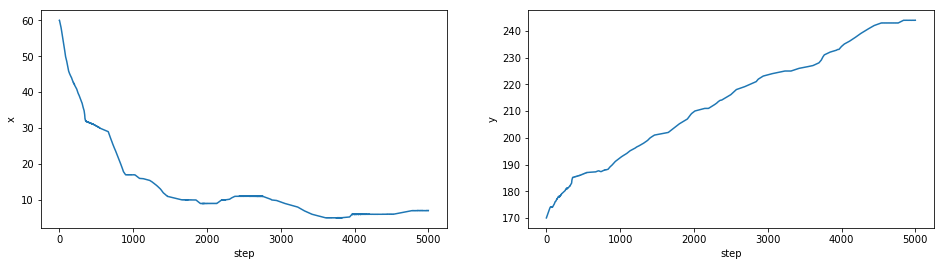

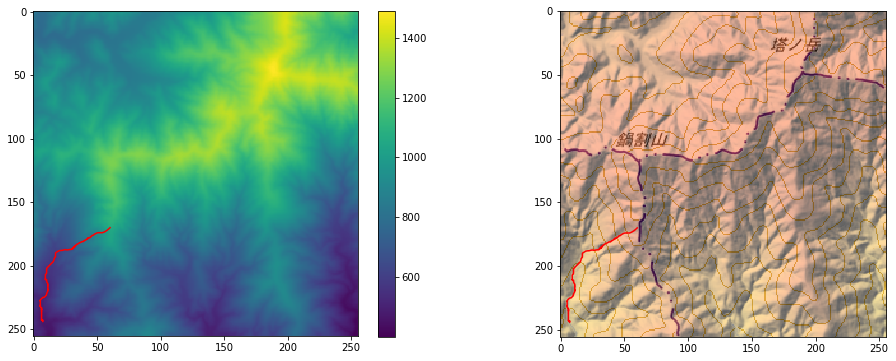

In [34]:
nabe_dem = get_maps([13, 7262, 3232], tile_type="dem", ext="txt")
nabe_std = get_maps([13, 7262, 3232])
nabe_relief = get_maps([13, 7262, 3232], tile_type="relief")

alpha = 0.5
mixed_map = nabe_std*(1.-alpha) + nabe_relief*alpha

show_gradient_descent(nabe_dem, (60, 170), map_=mixed_map.astype(np.uint8), eps=0.01, max_step=5000)

## memo
- 初期位置はガウス分布でたくさんやる　反対側に転がるのは除外
- epsはどれぐらい？ 1stepに1pixel以内ぐらいがいい
- なんらかの点に基づきカーネル密度推定
- (a)停止条件を指定して、停止点を↑に使う？ 停止条件がややこしい△
- (b)各通過点について、速度(1stepあたりのx, yの移動量)が小さい（=勾配小さい）ほど重みの大きいカーネル密度推定？
- さらに、ステップが経過しているほど重みが小さくなるべき（それ以前に停止している可能性が高まるため。cf: 事象生起期間の指数分布）
- epsが小さいほど通過点が多くなるので注意
- 木によるランダムな方向転換の加味
- 過去のデータがないのでパラメータは決め打ちしかなさそう
    - 重み、初期位置のばらつき、方向転換の度合い、カーネル密度推定のバンド幅、eps